## ***Visión por Computadora - 2024***

Stefano Aragoni, Carol Arévalo, José González, Luis Santos

-----------

### *Proyecto 01 - Problema 2*

A partir de las imágenes groundtruth, construir un algoritmo que genere una discretización de la estructura arterial. Representaremos esta discretizaiónn mediante un grafo de vértices y aristas que conectan dichos vértices.

Su algoritmo debe recibir como input la imagen groundtruth, y los par´ametros espec´ıficos que sus m´etodos y estrategias requieran.

Como salida, el algoritmo debe devolver lo siguiente:

1. Un archivo estructurado (puede ser en formato .json, .yml, o similares), en donde se especifica la estructura del grafo
obtenido:
- listado de nodos, y sus coordenadas (fila, columna) dentro de la imagen groundtruth.
- listado de nodos extremos (indicados en verde en la figura).
- listado de nodos de bifurcación (indicados en rojo en la figura).
- listado de nodos de trifurcación (indicados en azul, en la figura no hay).
- listado de nodos intermedios (indicados en gris en la figura). Estos nodos se añaden a conveniencia, para mantener el grafo resultante lo más similar a la estructura arterial en la imagen.
- listado de aristas conectoras que conforman el grafo (indicadas en amarillo en la imagen).

2. Una imagen que guarde la visualización del grafo obtenido.





-----------

#### *Importar librerías*

Como primer paso, se importan las librerías necesarias para el desarrollo del problema.

In [15]:
import os

import matplotlib.pyplot as plt
import numpy as np

import cv2
from scipy import ndimage
from PIL import Image

from skimage import io, color, filters, feature, morphology, exposure, util
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.util import invert
from skimage.filters import threshold_otsu, gaussian, threshold_local
from skimage.morphology import binary_opening, binary_closing, binary_dilation, binary_erosion, disk, remove_small_objects
from skimage.morphology import skeletonize

from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

---------

#### *Cargar imágenes*

Luego, se procede a cargar las imágenes que se utilizarán para el desarrollo del problema.

- Para llevar a cabo este proceso, se definió una función llamada `load_images`. Esta recibe como parámetro el nombre de la imagen a cargar y retorna la imagen en escala de grises.

In [16]:
def load_image(name_of_image):

    # Definir el directorio de la base de datos
    directory = "./database"

    # Importar imagen en escala de grises
    image = cv2.imread(os.path.join(directory, name_of_image), cv2.IMREAD_GRAYSCALE)

    #Retornar imagen
    return image

- Posteriormente, se definió un ciclo `for` para cargar las 40 imágenes que se utilizarán para el desarrollo del problema.

In [17]:
# Array para almacenar las imagenes groundtruth
groundtruth_images = []
processed_images = []

# Cargar imagenes
for i in range(1, 21):
    
    groundtruth = f"{i}_gt.pgm"

    gt = load_image(groundtruth) > 0
    groundtruth_images.append(gt)

- Finalmente, se programó una función para procesar y mostrar las imágenes cargadas.

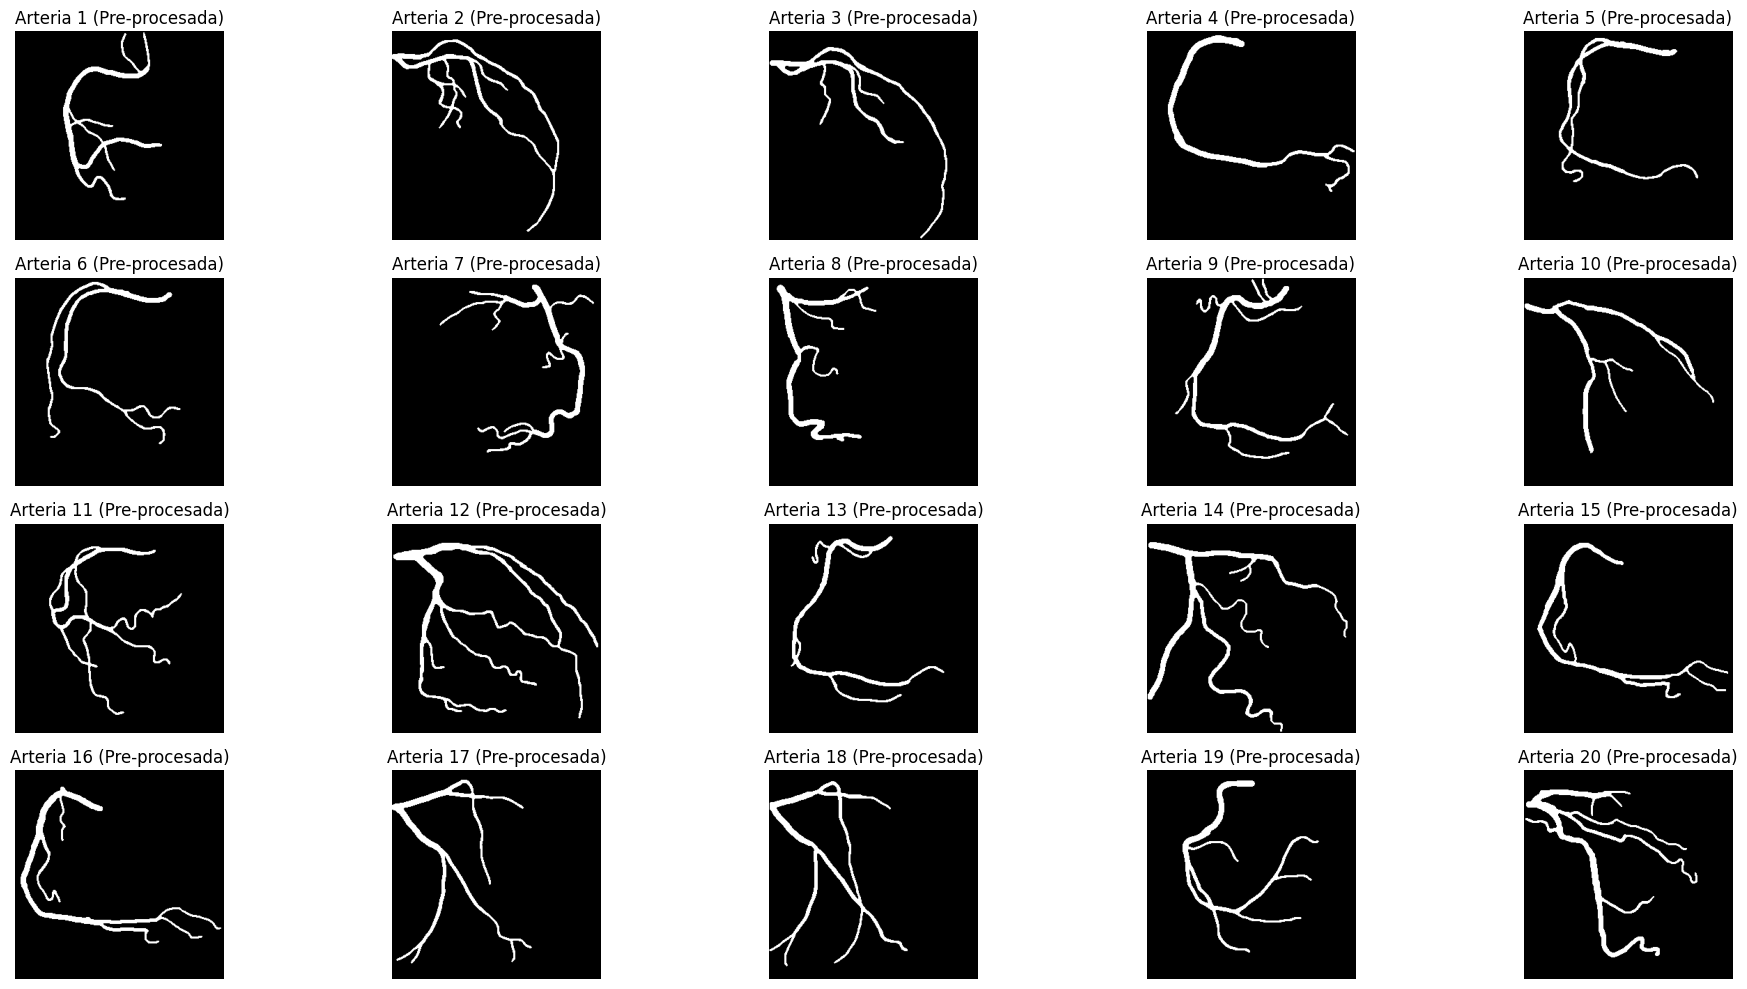

In [18]:
# Aplicar un filtro gaussiano para suavizar la imagen
smoothed_images = [gaussian(image, sigma=1) for image in groundtruth_images]

# Aplicar umbralización para convertir las imágenes a binario
# Este umbral puede ser global (simple) o adaptativo (local) dependiendo de las imágenes
thresholded_images = [image > threshold_otsu(image) for image in smoothed_images]

# Mostrar las imágenes pre-procesadas
num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Contador de subfiguras
index = 0

# Iterar sobre las imágenes pre-procesadas y mostrarlas en la cuadrícula
for i in range(20):  
    # Mostrar imagen pre-procesada
    axes[index // num_cols, index % num_cols].imshow(thresholded_images[i], cmap='gray')
    axes[index // num_cols, index % num_cols].axis('off')
    axes[index // num_cols, index % num_cols].set_title(f'Arteria {i + 1} (Pre-procesada)')

    # Aumentar el contador de subfiguras
    index += 1  

# Ajustar el espacio entre las subfiguras
plt.tight_layout()
plt.show()


---------

#### *Detección de características*

Detectar puntos extremos, bifurcaciones y posiblemente trifurcaciones usando la transformada de Hough para detectar curvas o utilizando un análisis de la estructura de la imagen (como el análisis de esqueleto).

- Esqueletización: Se convierten las arterias a su forma esquelética, que es una representación de un píxel de ancho de las arterias.

In [42]:
skeleton_images = [skeletonize(image) for image in thresholded_images]

- Análisis de esqueleto: Se analiza el esqueleto para identificar nodos y conexiones. Más específicamente, se está buscando trifurcaciones y bifurcaciones.

In [43]:
def analyze_skeleton(skeleton):
    # Preparar arrays para almacenar las coordenadas de los puntos
    bifurcation_points = []
    endpoint_points = []
    trifurcation_points = []  # Lista para puntos de cuadrifurcación
    
    # Obtener las dimensiones de la imagen
    dimensions = skeleton.shape
    
    # Analizar cada píxel del esqueleto
    for i in range(1, dimensions[0]-1):
        for j in range(1, dimensions[1]-1):
            # Contar los vecinos del píxel
            p = skeleton[i, j]
            neighbors = skeleton[i-1:i+2, j-1:j+2].sum() - p
            
            # Si el píxel es parte del esqueleto y tiene exactamente un vecino, es un extremo
            if p == 1 and neighbors == 1:
                endpoint_points.append((j, i))
            # Si el píxel es parte del esqueleto y tiene exactamente tres vecinos, es una bifurcación
            elif p == 1 and neighbors == 3:
                bifurcation_points.append((j, i))
            # Si el píxel es parte del esqueleto y tiene exactamente 4 vecinos, es una trifurcación
            elif p == 1 and neighbors == 5:
                trifurcation_points.append((j, i))
    
    return bifurcation_points, endpoint_points, trifurcation_points


# Encontrar puntos de bifurcación, extremos y trifurcación
analized_skeleton_images = [analyze_skeleton(image) for image in skeleton_images]

- Añadir nodos intermedios: Se añaden nodos intermedios a lo largo de los segmentos arteriales para preservar la geometría de la arteria en el grafo.

In [46]:
def getNextPoint(skeleton, point, lastPoints):
    neighbors = skeleton[point[1]-1:point[1]+2, point[0]-1:point[0]+2]
    index = []
    for x in range(3):
        for y in range(3):
            if x == 1 and y == 1:
                continue
            if neighbors[x][y] == True:
                index.append((y + point[0] - 1, x + point[1] - 1))
    
    for lastPoint in lastPoints:
        for i in range(len(index)):
            if i >= len(index): 
                break
            if (index[i][0] == lastPoint[0] and index[i][1] == lastPoint[1]):
                index.remove(index[i])
    
    if not index:
        return None

    return index[0]

def getAllNeighbors(skeleton, point):
    neighbors = skeleton[point[1]-1:point[1]+2, point[0]-1:point[0]+2]
    index = []
    for x in range(3):
        for y in range(3):
            if x == 1 and y == 1:
                continue
            if neighbors[x][y] == True:
                index.append((y + point[0] - 1, x + point[1] - 1))

    for i in range(len(index)):
        if index[i][0] == point[0] and index[i][1] == point[1]:
            index.remove(index[i])
            break

    if not index:
        return None
    
    return index

def addIntermediateNodes(skeleton, bifurcations, trifurcations, endpoints):
    previousPoint = [endpoints[0]]
    intermediatePoints = [endpoints[0]]
    stack = []
    count = 0
    
    currentPoint = getNextPoint(skeleton, endpoints[0], previousPoint)

    while currentPoint:
        if currentPoint in endpoints:
            intermediatePoints.append(currentPoint)
            count = 0
            
        if currentPoint in bifurcations or currentPoint in trifurcations:
            intermediatePoints.append(currentPoint)
            count = 0

            previousPoint.append(currentPoint)
            neighbors = getAllNeighbors(skeleton, currentPoint)

            for neighbor in neighbors:
                for i in range(len(previousPoint)):
                    if neighbor[0] == previousPoint[i][0] and neighbor[1] == previousPoint[i][1]:
                        neighbors.remove(neighbor)
                        break

            currentPoint = neighbors.pop(0)

            for neighbor in neighbors:
                stack.append(neighbor)

        else:
            count += 1

            if count % 30 == 0:
                intermediatePoints.append(currentPoint)
            
        previousPoint.append(currentPoint)
        nextPoint = getNextPoint(skeleton, currentPoint, previousPoint)

        if nextPoint:
            currentPoint = nextPoint
        else:
            if stack:
                currentPoint = stack.pop()
                previousPoint.append(currentPoint)
                nextPoint = getNextPoint(skeleton, currentPoint, previousPoint)
            else:
                currentPoint = None

    return intermediatePoints

# Mostar nodos intermedios
completed_skeleton_images = []
for skeleton, data in zip(skeleton_images, analized_skeleton_images):
    bifurcations, endpoints, trifurcations = data
    visualized_image = addIntermediateNodes(skeleton, bifurcations, trifurcations, endpoints)
    completed_skeleton_images.append(visualized_image)

- Generación de aristas: Se conectan aristan para formar el grafo usando Dijsktra.

In [49]:
def connectPoints(skeleton, endpoints, intermediateNodes, bifurcations, trifurcations):
    connectedSkeleton = np.zeros_like(skeleton)
    past = endpoints[0]
    bifurcationPoints = []
    trifurcationPoints = []
    trifurcation = True
    skip = False

    for node in intermediateNodes:    
        if skip:
            if trifurcation:
                past = trifurcationPoints.pop()
                bifurcationPoints.append(past)
                trifurcation = False
            else:
                past = bifurcationPoints.pop()
            
            skip = False
            
        for point in zip(*np.round(np.linspace(past, node, 100)).astype(int).T):
            connectedSkeleton[point[1], point[0]] = True
        
        if node in bifurcations:
            bifurcationPoints.append(node)
            trifurcation = False
        if node in trifurcations:
            trifurcationPoints.append(node)
            trifurcation = True
        if node in endpoints and node != intermediateNodes[0]:
            skip = True

        past = node

    return connectedSkeleton

# Conectar los puntos de inicio y fin de los tramos con cambio de dirección 
connected_skeleton_images = [
        connectPoints(skeleton, endpoints, intermediateNodes, bifurcations, trifurcations) for skeleton, 
        (bifurcations, endpoints, trifurcations), 
        intermediateNodes in zip(skeleton_images, analized_skeleton_images, completed_skeleton_images)
    ]

---------

#### *Imágenes Resultantes*

Utilizando todas las funciones anteriormente definidas, se generan las imágenes resultantes.


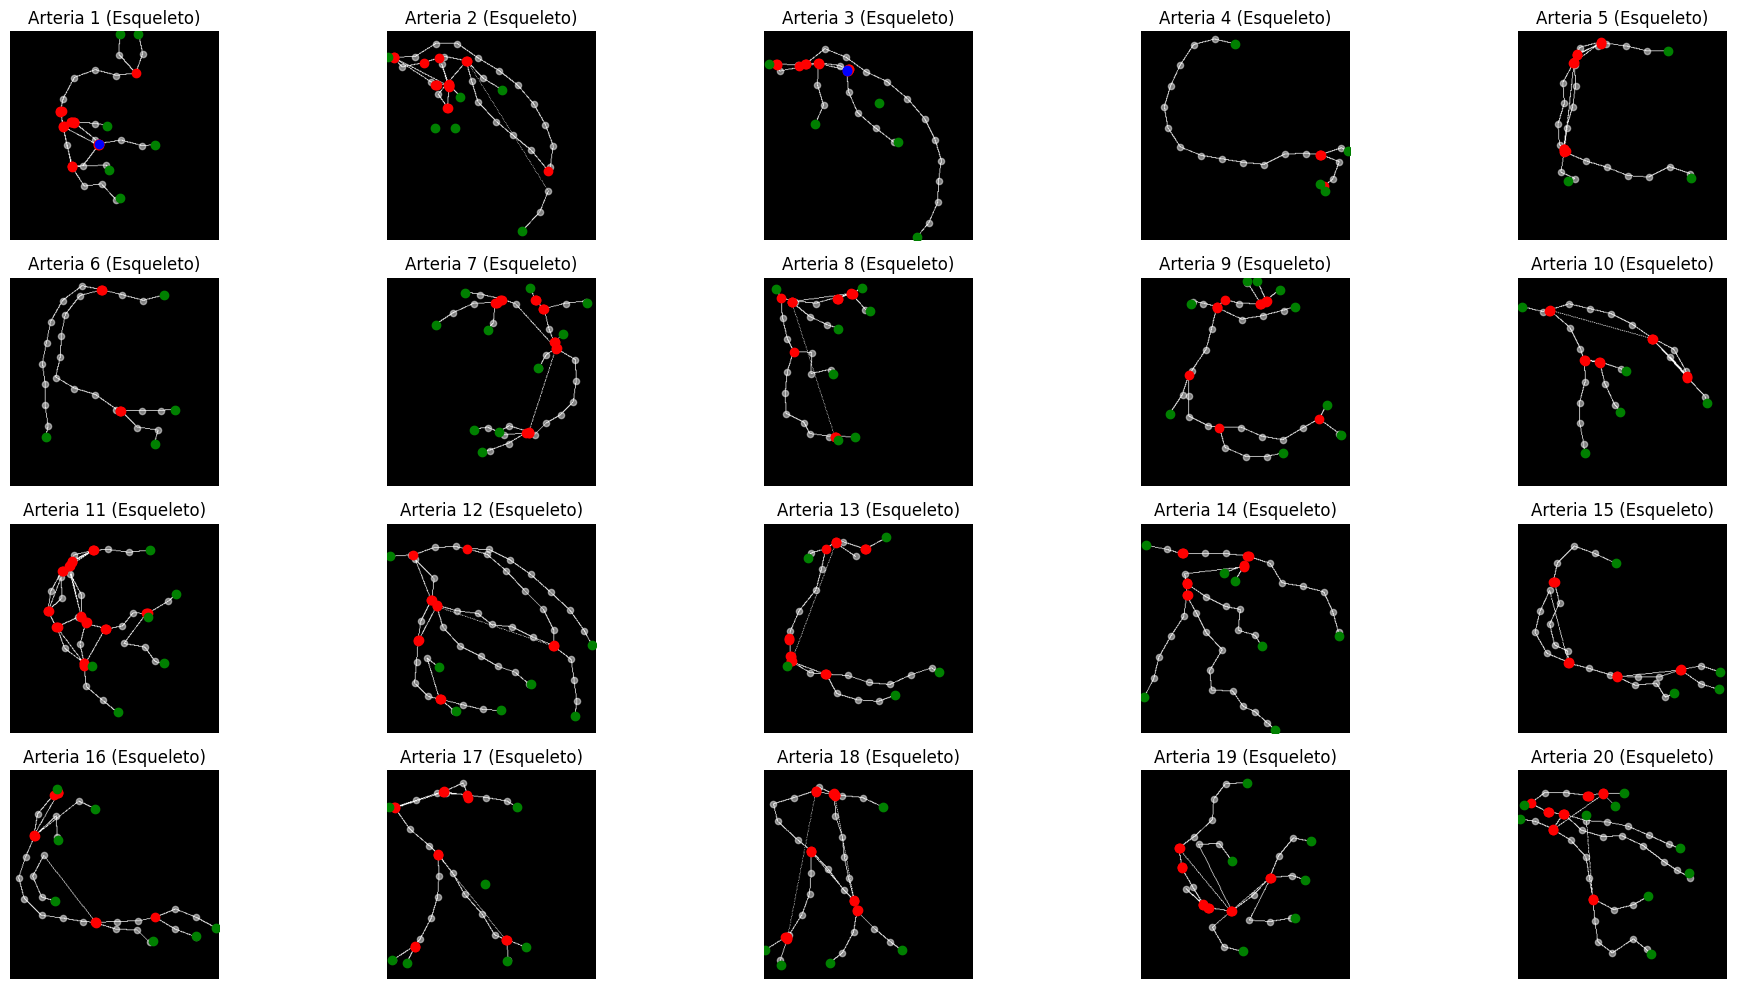

In [51]:
# Mostrar las imágenes esqueletizadas con puntos de bifurcación y extremos
num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Iterar sobre las imágenes esqueletizadas y mostrarlas en la cuadrícula
for i in range(20):  # Asumiendo que hay 20 imágenes
    
    skeleton_image = skeleton_images[i]  # Esta es la imagen esqueletizada original

    edges_image = connected_skeleton_images[i]  # aristas conectadas
    bifurcations, endpoints, trifurcations = analized_skeleton_images[i]   # bifurcaciones, enpoints, trifurcaciones
    intermediateNodes = completed_skeleton_images[i] # puntos intermdios


    axes[i // num_cols, i % num_cols].imshow(edges_image, cmap='gray')

    if intermediateNodes:
        axes[i // num_cols, i % num_cols].scatter(*zip(*intermediateNodes), color='white', alpha=0.5, s=20)
    if bifurcations:
        axes[i // num_cols, i % num_cols].scatter(*zip(*bifurcations), color='red')
    if trifurcations:
        axes[i // num_cols, i % num_cols].scatter(*zip(*trifurcations), color='blue')
    if endpoints:
        axes[i // num_cols, i % num_cols].scatter(*zip(*endpoints), color='green')

    axes[i // num_cols, i % num_cols].axis('off')
    axes[i // num_cols, i % num_cols].set_title(f'Arteria {i + 1} (Esqueleto)')

# Ajustar el espacio entre las subfiguras
plt.tight_layout()
plt.show()

---------

#### *Construcción del grafo:*
Se utilizan los puntos identificados para construir un grafo en formato json


In [ ]:
for x in range(len(connected_skeleton_images)):
    bifurcations, endpoints, trifurcations = analized_skeleton_images[x] 
    intermediateNodes = completed_skeleton_images[x]
    aristas = aristas_list[x]

    if len(bifurcations) > 0:
        jsonData = '{"bifurcations": ['
        for i in range(len(bifurcations)):
            jsonData += '\n\t{"x": ' + str(bifurcations[i][0]) + ', "y": ' + str(bifurcations[i][1]) + '}'
            if i != len(bifurcations) - 1:
                jsonData += ", "
        jsonData += "\n], "

    if len(trifurcations) > 0:
        jsonData += '"trifurcations": ['
        for i in range(len(trifurcations)):
            jsonData += '\n\t{"x": ' + str(trifurcations[i][0]) + ', "y": ' + str(trifurcations[i][1]) + '}'
            if i != len(trifurcations) - 1:
                jsonData += ", "
        jsonData += "\n], "

    jsonData += '"endpoints": ['
    for i in range(len(endpoints)):
        jsonData += '\n\t{"x": ' + str(endpoints[i][0]) + ', "y": ' + str(endpoints[i][1]) + '}'
        if i != len(endpoints) - 1:
            jsonData += ", "
    jsonData += "\n], "

    jsonData += '"intermediateNodes": ['
    for i in range(len(intermediateNodes)):
        jsonData += '\n\t{"x": ' + str(intermediateNodes[i][0]) + ', "y": ' + str(intermediateNodes[i][1]) + '}'
        if i != len(intermediateNodes) - 1:
            jsonData += ", "
    jsonData += "\n], "

    jsonData += '"aristas": ['
    for i in range(len(aristas)):
        jsonData += '\n\t{"x1": ' + str(aristas[i][0][0]) + ', "y1": ' + str(aristas[i][0][1]) + ', "x2": ' + str(aristas[i][1][0]) + ', "y2": ' + str(aristas[i][1][1]) + '}'
        if i != len(aristas) - 1:
            jsonData += ", "
    jsonData += "\n]"
    jsonData += "}"

    with open("json/skeleton_" + str(x + 1) + ".json", "w") as file:
        file.write(jsonData)